In [1]:
from tools.log_controller import LogController
from pathlib import Path

log_controller = LogController(config_path=Path('config', 'logging_config.json'))
log_controller.start()

In [2]:
from core.data_repository import DataRepository
from pathlib import Path


data_repository = DataRepository(repo_path=Path('repo'))
AMZN_periodic_data = data_repository.get_dataframes()['AMZN']

 2025-10-14 13:21:20 - data_repository - INFO - Loaded: AAPL
 2025-10-14 13:21:20 - data_repository - INFO - Loaded: AMZN_enhanced
 2025-10-14 13:21:20 - data_repository - INFO - Loaded: AMZN_enhanced
 2025-10-14 13:21:20 - data_repository - INFO - Loaded: IBM
 2025-10-14 13:21:20 - data_repository - INFO - Loaded: AMZN
 2025-10-14 13:21:20 - data_repository - INFO - Loaded periodic stock market data for: {'AAPL', 'IBM', 'AMZN', 'AMZN_enhanced'}
 2025-10-14 13:21:20 - data_repository - INFO - Loaded: IBM
 2025-10-14 13:21:20 - data_repository - INFO - Loaded: AMZN
 2025-10-14 13:21:20 - data_repository - INFO - Loaded periodic stock market data for: {'AAPL', 'IBM', 'AMZN', 'AMZN_enhanced'}


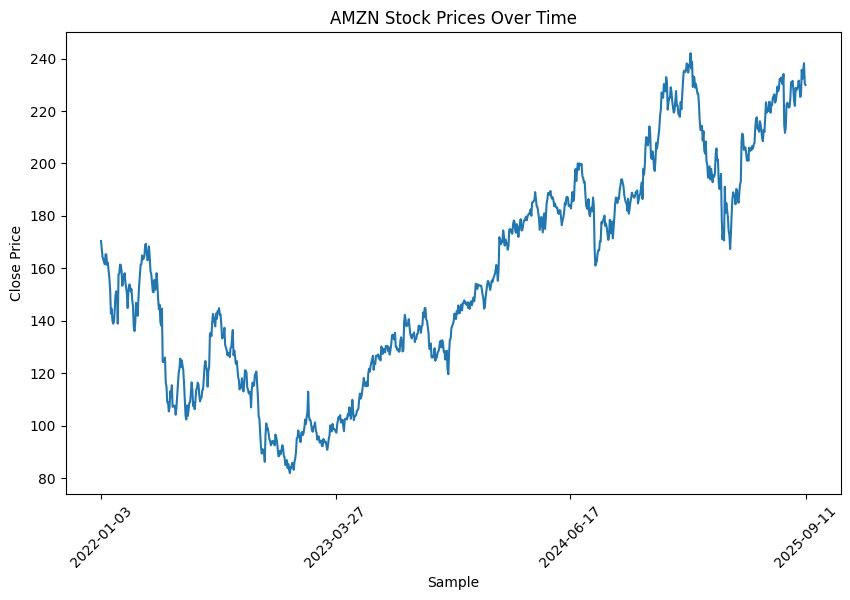

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.figure(figsize=(10, 6))
sns.lineplot(data=AMZN_periodic_data, x=AMZN_periodic_data.index, y='Close')
plt.xticks(ticks=np.linspace(0, len(AMZN_periodic_data.index) - 1, 4, dtype=int),rotation=45)
plt.title('AMZN Stock Prices Over Time')
plt.xlabel('Sample')
plt.ylabel('Close Price')
plt.show()

In [4]:
# Filter
from core.data_preparator import DataPreparator
import numpy as np

AMZN_periodic_data_filtered = DataPreparator.apply_kalman_filter(
    AMZN_periodic_data,
    F=np.array([[1, 1], [0, 1]]),
    H=np.array([[1, 0]]),
    Q=np.array([[1, 0], [0, 3]])*0.01,
    R=np.array([[10]]),
    P=np.array([[1, 0], [0, 1]])*1000,
)

 2025-10-14 13:21:22 - data_preparator - INFO - Applying Kalman filter to target column: Close


In [5]:
from core.data_preparator import DataPreparator

timesteps_lookback = 3

AMZN_supervised_data = DataPreparator.reformat_periodic_to_supervised_data(
    dataframe=AMZN_periodic_data_filtered,
    target_column='Close',
    t=timesteps_lookback
)



 2025-10-14 13:21:23 - data_preparator - INFO - Preparing data for target column: Close, with t=3


In [6]:
# Attach original (unfiltered) Close for evaluation by aligned index
AMZN_supervised_data['Close_original'] = AMZN_periodic_data.loc[AMZN_supervised_data.index, 'Close'].astype(float).values
AMZN_supervised_data.head()

,Close,Close_0,Close_1,Close_2,Close_original
Date,,,,,
2022-01-06,162.710617,164.438725,167.576142,170.404495,163.253998
2022-01-07,161.637244,162.710617,164.438725,167.576142,162.554001
2022-01-10,160.614620,161.637244,162.710617,164.438725,161.485992
2022-01-11,161.921718,160.614620,161.637244,162.710617,165.362000
2022-01-12,162.735658,161.921718,160.614620,161.637244,165.207001


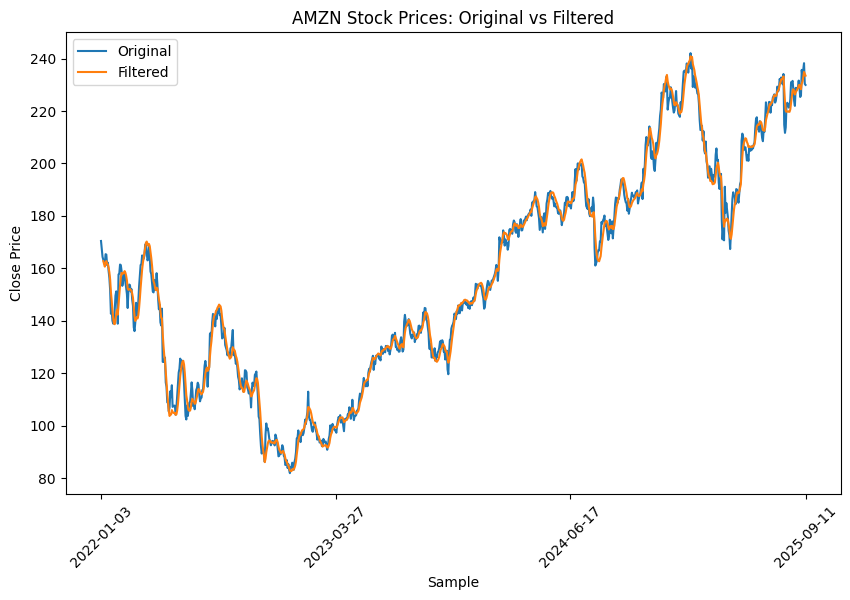

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.figure(figsize=(10, 6))
sns.lineplot(data=AMZN_periodic_data, x=AMZN_periodic_data.index, y='Close', label='Original')
sns.lineplot(data=AMZN_supervised_data, x=AMZN_supervised_data.index, y='Close', label='Filtered')
plt.xticks(ticks=np.linspace(0, len(AMZN_periodic_data.index) - 1, 4, dtype=int),rotation=45)
plt.title('AMZN Stock Prices: Original vs Filtered')
plt.xlabel('Sample')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [8]:
from core.dataset import StockDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

AMZN_train_dataset, AMZN_test_dataset = train_test_split(AMZN_supervised_data, test_size=.1, shuffle=False, random_state=42)
AMZN_train_dataset, AMZN_validation_dataset = train_test_split(AMZN_train_dataset, test_size=.2, shuffle=False, random_state=42)

In [9]:
targets = ['Close', 'Close_original']
features = [col for col in AMZN_supervised_data.columns if col not in targets]

target = targets[0]
target_original = targets[1]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_y_original = MinMaxScaler()

scaler_X.fit(AMZN_train_dataset[features])
scaler_y.fit(AMZN_train_dataset[[target]])
scaler_y_original.fit(AMZN_train_dataset[[target_original]])

X_train_scaled = scaler_X.transform(AMZN_train_dataset[features])
y_train_scaled = scaler_y.transform(AMZN_train_dataset[[target]])
y_train_original_scaled = scaler_y_original.transform(AMZN_train_dataset[[target_original]])

X_validation_scaled = scaler_X.transform(AMZN_validation_dataset[features])
y_validation_scaled = scaler_y.transform(AMZN_validation_dataset[[target]])
y_validation_original_scaled = scaler_y_original.transform(AMZN_validation_dataset[[target_original]])


X_test_scaled = scaler_X.transform(AMZN_test_dataset[features])
y_test_scaled = scaler_y.transform(AMZN_test_dataset[[target]])
y_test_original_scaled = scaler_y_original.transform(AMZN_test_dataset[[target_original]])


AMZN_train_scaled = pd.DataFrame(X_train_scaled, columns=features)
AMZN_train_scaled[[target]] = y_train_scaled
AMZN_train_scaled[[target_original]] = y_train_original_scaled

AMZN_validation_scaled = pd.DataFrame(X_validation_scaled, columns=features)
AMZN_validation_scaled[[target]] = y_validation_scaled
AMZN_validation_scaled[[target_original]] = y_validation_original_scaled


AMZN_test_scaled = pd.DataFrame(X_test_scaled, columns=features)
AMZN_test_scaled[[target]] = y_test_scaled
AMZN_test_scaled[[target_original]] = y_test_original_scaled


AMZN_train_dataset = AMZN_train_scaled
AMZN_validation_dataset = AMZN_validation_scaled
AMZN_test_dataset = AMZN_test_scaled

In [ ]:
AMZN_train_original = AMZN_train_dataset['Close_original']
AMZN_validation_original = AMZN_validation_dataset['Close_original']
AMZN_test_original = AMZN_test_dataset['Close_original']

AMZN_train_dataset.drop(columns=['Close_original'], inplace=True)
AMZN_validation_dataset.drop(columns=['Close_original'], inplace=True)
AMZN_test_dataset.drop(columns=['Close_original'], inplace=True)

In [11]:
AMZN_train_dataset = StockDataset(AMZN_train_dataset)
AMZN_validation_dataset = StockDataset(AMZN_validation_dataset)
AMZN_test_dataset = StockDataset(AMZN_test_dataset)

 2025-10-14 13:21:27 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close
 2025-10-14 13:21:27 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close
 2025-10-14 13:21:27 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close
 2025-10-14 13:21:27 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close
 2025-10-14 13:21:27 - dataset - INFO - Created stock dataset for AMZN, focusing target: Close


In [12]:
from models.lstm_model import LSTMStockModel

AMZN_base_model = LSTMStockModel(
    id='base_amzn_model',
    ticker='AMZN',
    input_dim=1,
    hidden_dim=64,
    layer_dim=1,
    output_dim=1
)

 2025-10-14 13:21:27 - model - INFO - Model(id=base_amzn_model,
ticker=('AMZN',),
input_dimension=1),
hidden_dimension=64,
layer_dimension=1,
output_dimension=1)


In [13]:
from torch.optim import Adam
from torch.nn import MSELoss

optimizer = Adam(AMZN_base_model.parameters(), lr=0.001)
loss_function = MSELoss()

In [14]:
from torch.utils.data import DataLoader
import torch
import numpy as np


AMZN_train_data_loader = DataLoader(AMZN_train_dataset, batch_size=16, shuffle=False)
AMZN_validation_data_loader = DataLoader(AMZN_validation_dataset, batch_size=10, shuffle=False)


train_rmse_list = []
val_rmse_list = []

predictions = []
actuals = []
epochs = 20

for epoch in range(epochs):
    # Training loop
    AMZN_base_model.train()
    train_loss = 0
    for X,y in AMZN_train_data_loader:
        optimizer.zero_grad()
        X, y = X.reshape(-1,timesteps_lookback,1), y.reshape(-1,1) # Adjust for t
        outputs, _ = AMZN_base_model(X)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predictions.extend(outputs.detach().numpy().flatten())
        actuals.extend(y.numpy().flatten())
        
    # Validation loop
    AMZN_base_model.eval()
    val_loss = 0
    with torch.no_grad():
        for X,y in AMZN_validation_data_loader:
            X, y = X.reshape(-1,timesteps_lookback,1), y.reshape(-1,1)
            outputs, _ = AMZN_base_model(X)
            val_loss += loss_function(outputs, y).item()
            
    train_rmse = np.sqrt(train_loss / len(AMZN_train_data_loader))
    val_rmse = np.sqrt(val_loss / len(AMZN_validation_data_loader))
    
    train_rmse_list.append(train_rmse)
    val_rmse_list.append(val_rmse)
        
    print(f'Epoch [{epoch+1}/{epochs}]')
    print(f'RMSE: {train_rmse:.4f}')
    print(f'Validation RMSE: {val_rmse:.4f}')

Epoch [1/20]
RMSE: 0.3299
Validation RMSE: 0.4513
Epoch [2/20]
RMSE: 0.2820
Validation RMSE: 0.4525
Epoch [3/20]
RMSE: 0.2253
Validation RMSE: 0.3279
Epoch [4/20]
RMSE: 0.2014
Validation RMSE: 0.2211
Epoch [5/20]
RMSE: 0.1595
Validation RMSE: 0.0657
Epoch [6/20]
RMSE: 0.1072
Validation RMSE: 0.0734
Epoch [4/20]
RMSE: 0.2014
Validation RMSE: 0.2211
Epoch [5/20]
RMSE: 0.1595
Validation RMSE: 0.0657
Epoch [6/20]
RMSE: 0.1072
Validation RMSE: 0.0734
Epoch [7/20]
RMSE: 0.0587
Validation RMSE: 0.0669
Epoch [8/20]
RMSE: 0.0384
Validation RMSE: 0.0481
Epoch [9/20]
RMSE: 0.0378
Validation RMSE: 0.0434
Epoch [7/20]
RMSE: 0.0587
Validation RMSE: 0.0669
Epoch [8/20]
RMSE: 0.0384
Validation RMSE: 0.0481
Epoch [9/20]
RMSE: 0.0378
Validation RMSE: 0.0434
Epoch [10/20]
RMSE: 0.0383
Validation RMSE: 0.0400
Epoch [11/20]
RMSE: 0.0389
Validation RMSE: 0.0374
Epoch [12/20]
RMSE: 0.0400
Validation RMSE: 0.0360
Epoch [10/20]
RMSE: 0.0383
Validation RMSE: 0.0400
Epoch [11/20]
RMSE: 0.0389
Validation RMSE: 0.

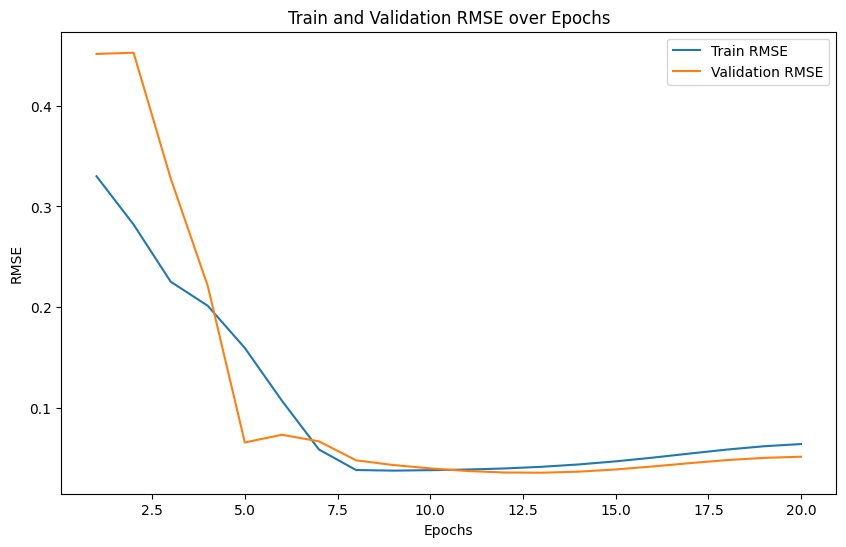

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 6))
sns.lineplot(x=epochs_range, y=train_rmse_list, label='Train RMSE')
sns.lineplot(x=epochs_range, y=val_rmse_list, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Train and Validation RMSE over Epochs')
plt.legend()
plt.show()

In [16]:
AMZN_base_model.eval()
AMZN_test_data_loader = DataLoader(AMZN_test_dataset, batch_size=10, shuffle=False)
test_loss = 0

predictions = []
actuals = []

with torch.no_grad():
    for X,y in AMZN_test_data_loader:
        X, y = X.reshape(-1,timesteps_lookback,1), y.reshape(-1,1)
        outputs, _ = AMZN_base_model(X)
        test_loss += loss_function(outputs, y).item()
        predictions.extend(outputs.numpy().flatten())
        actuals.extend(y.numpy().flatten())

test_rmse = np.sqrt(test_loss / len(AMZN_test_data_loader))
print(f'Test RMSE: {test_rmse:.4f}')

Test RMSE: 0.0252


Test Loss (RMSE) on original scale: 2.9802


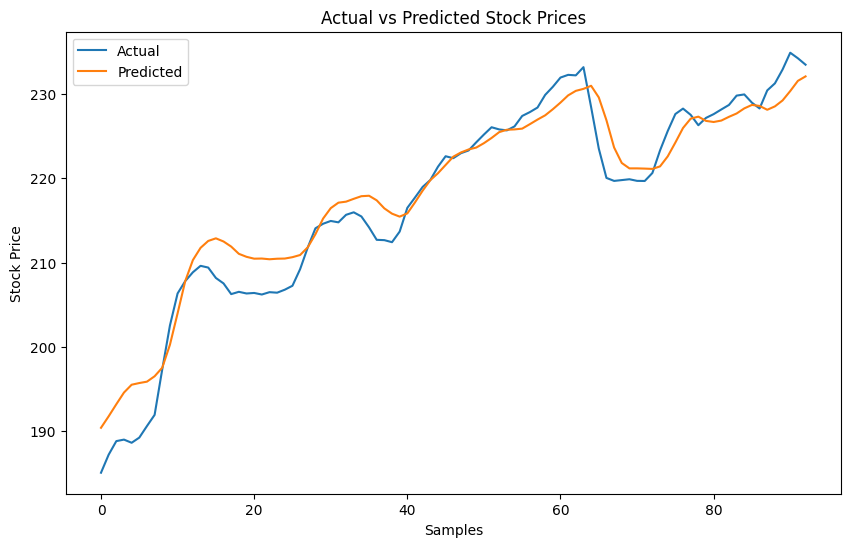

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

original_test_loss = np.sqrt(loss_function(torch.tensor(predictions), torch.tensor(actuals)).item())
print(f'Test Loss (RMSE) on original scale: {original_test_loss:.4f}')

errors = actuals - predictions

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(actuals)), y=actuals, label='Actual')
sns.lineplot(x=range(len(predictions)), y=predictions, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

Test Loss (RMSE) on unfiltered original scale: 5.6656


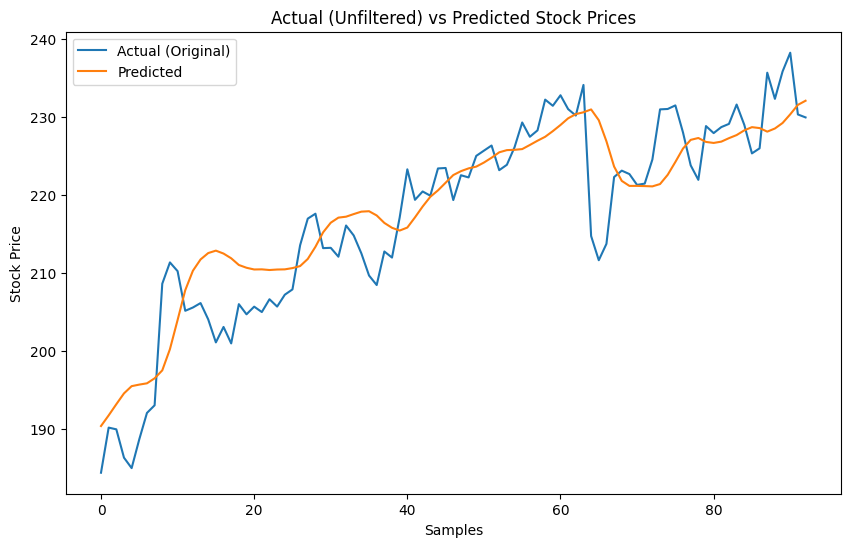

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Inverse-transform the original (unfiltered) target series
actuals_original = scaler_y_original.inverse_transform(
    AMZN_test_original.to_numpy().reshape(-1, 1)
).flatten()

unfiltered_test_loss = np.sqrt(loss_function(torch.tensor(predictions), torch.tensor(actuals_original)).item())
print(f'Test Loss (RMSE) on unfiltered original scale: {unfiltered_test_loss:.4f}')

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(actuals_original)), y=actuals_original, label='Actual (Original)')
sns.lineplot(x=range(len(predictions)), y=predictions, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('Stock Price')
plt.title('Actual (Unfiltered) vs Predicted Stock Prices')
plt.legend()
plt.show()

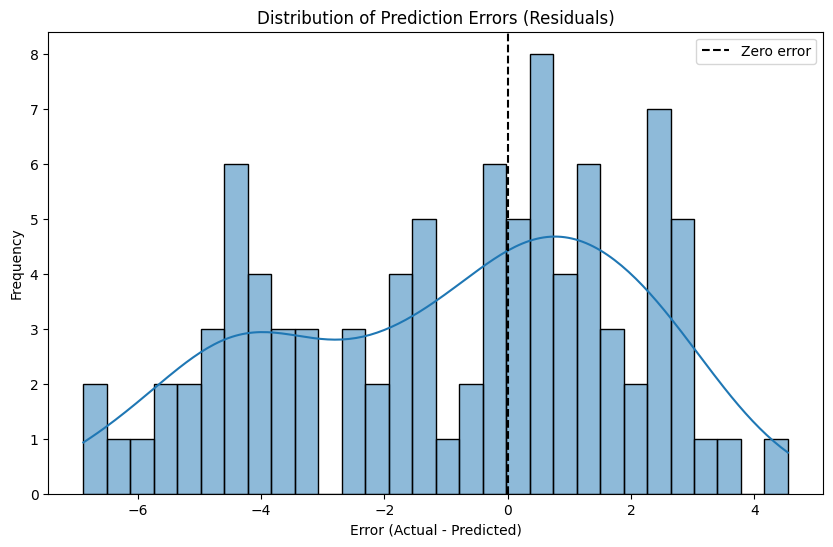

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.axvline(0, color='black', linestyle='--', label='Zero error')
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.show()